In [1]:
import os
import glob
import imageio
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils import get_cartesian_mask, get_kspace, kspace_to_image
from_space = lambda x: kspace_to_image(x, (2, 3)).real
from training_utils.helpers import estimate_to_image
from scripts.train_resunet import load_model
from utils import get_cartesian_mask
from train import build_model

import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 0
    torch.cuda.set_device(gpu)
    print("num GPUs", torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

class rMSELoss(torch.nn.Module):
    def __init__(self):
        super(rMSELoss,self).__init__()

    def forward(self, net_input, x, y):
        criterion = nn.MSELoss()
        loss = -criterion(x,y)
        return loss

def plot_(ims,titles,scores):
    fig = plt.figure(figsize=(18,10))
    for i in range(len(ims)):
        ax = fig.add_subplot(1,len(ims),i+1)
        ax.imshow(ims[i],'gray')
        ax.axis('off')
        title = titles[i]
        if title != 'ground truth':
            title += ' PSNR: %0.2f'%(scores[i])
        ax.set_title(title)
    plt.show()
    
def norm(vol):
    vol_tmp = vol - vol.min()
    return vol_tmp / vol_tmp.max()

def load_model_irim(checkpoint_file, ddp=False):
    if not ddp:
        checkpoint = torch.load(checkpoint_file)
    else:
        device_id = torch.cuda.current_device()
        checkpoint = torch.load(checkpoint_file, map_location=lambda storage, loc: storage.cuda(device_id))
    args = checkpoint['args']
    model = build_model(args)
    model.load_state_dict(checkpoint['model'])
    return checkpoint, model

2023-01-27 15:50:24.264535: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


num GPUs 3


# construct 1,080 and 108 slices file

In [2]:
files = glob.glob('../Alzheimer/vol_test_/*/*.npz')

random.seed(9001)
slices = []
for file in files:
    y = norm(np.load(file)['label']) # y in range of [0, 1]
    sample_ns = random.sample(list(range(len(y))), 1)
    for sample_n in sample_ns:
        slices.append(y[sample_n])

np.save('../Alzheimer/testvol_adv/file.npy', np.array(slices))

# Required functions

In [2]:
def runner(net, # network model
        # ksp, # (full) k-space, old input
        label, # ground truth image; new input
        eps = 0.04,
        num_iter = 5000,
        LR = 0.01,
        mask = None,
        devices = [torch.device("cuda:0")],
        weight_decay=0,
        model_type='unet',
        retain_graph = False,
       ):
    # set model grads to false
    # for param in net.parameters():
    #     param.requires_grad = False
    ###################### fixed reconstruction from non-perturbed data ######################   
    mask = torch.from_numpy(mask[None, None, :, :].astype(np.float32)).cuda().detach() # shape [1,1,256,256]
    y = torch.from_numpy(label.reshape(-1, 1, 256, 256).astype(np.float32)).to('cuda') # shape [1,1,256,256]
    ksp = get_kspace(y, axes=(2, 3)).clone() # shape [1,1,256,256]
    masked_ksp = ksp * mask # shape [1,1,256,256]
    inp2 = masked_ksp.to('cuda')
    net.eval()

    if model_type == 'unet':
        out2 = net(ksp_y=inp2, mask=mask)

    elif model_type == 'irim':
        output = net.forward(ksp_y=inp2, mask_c=mask, metadata=None)
        out2 = estimate_to_image(output)    
    # torch.cuda.empty_cache()

    ###################### prepare adversarial variable ###################### 
    shape = ksp.shape
    print("input shape: ", shape)
    net_input = Variable(torch.zeros(shape)).type(dtype).to(devices[0])
    net_input.data.normal_()
    net_input.data *= torch.norm(ksp)/torch.norm(net_input)/10000    #1./1e3
    net_input = net_input.type(dtype).to(devices[0])
    net_input.requires_grad = True
    p = [net_input]

    optimizer = torch.optim.Adam(p, lr=LR, weight_decay=weight_decay)
    mse = rMSELoss()
    mse_ = np.zeros(num_iter) # list of zeros

    ###################### reconstruction from perturbed data ######################
    pert_recs = []
    R = []
    norm_ratios = []
    ctr = 0

    for i in range(num_iter):
        inp = (net_input + ksp) * mask # perturb full k-space and subsampling
        inp = inp.to('cuda') # masked ksp
        if model_type == 'unet':
            out = net(ksp_y=inp, mask=mask)

        elif model_type == 'irim':
            output = net.forward(ksp_y=inp, mask_c=mask, metadata=None)
            out = estimate_to_image(output) 
        pert_recs.append(out.data.cpu().numpy()[0])

        def closure():
            optimizer.zero_grad()
            loss = mse(net_input.to(devices[-1]), out, out2)
            loss.backward(retain_graph=retain_graph)
            mse_[i] = loss.data.cpu().numpy()
            if i % 10 == 0:
                print ('Iteration %05d   loss: %f norm ration: %03f' % (i, mse_[i], 
                                                                        torch.norm(net_input) / torch.norm(ksp)), '\r', end='')
            return loss   

        loss = optimizer.step(closure)
        ### projection onto the l2-norm ball denoted by eps 
        if torch.norm(net_input.data) / torch.norm(ksp) > eps:
            net_input.data = net_input.data * torch.norm(ksp) / (torch.norm(net_input.data) + 1e-10) # 1e-10 is a stabilizer
            net_input.data = net_input.data * eps
            ctr += 1
        R.append(net_input.data.cpu())
        norm_ratios = [torch.norm(net_input) / torch.norm(ksp)] + norm_ratios
        ### ending constraints
        if ctr > 100: # if more than 100 projections have been done
            print('ctr break!')
            break
        if len(norm_ratios) >= 200: # if the perturbation norm doesn't change more than 0.1 over 200 iterations
            if norm_ratios[0] - norm_ratios[-1] < 0.01:
                print('norm break!')
                break
            else:
                norm_ratios.pop()
    return R, mse_, out2.data.cpu().numpy()[0], pert_recs

In [3]:
class args():
    def __init__(self):
        self.npy_root = '../Alzheimer/testvol_adv/'
        self.checkpoint_path = './checkpoints/irim/best_model.pt'
        self.resolution = 256
        self.n_keep = 32
        self.irim = True
args = args()

file = glob.glob(os.path.join(args.npy_root, 'file.npy'))[0]
if args.irim:
    checkpoint, model = load_model_irim(args.checkpoint_path, ddp=False)
else:
    _, model, _ = load_model(args.checkpoint_path)
mask = get_cartesian_mask([args.resolution, args.resolution], args.n_keep)

if file.endswith('.npy'):
    test_imgs = np.load(file)
orig = test_imgs[10]

In [4]:
e = 0.08
R, loss, clean_rec, pert_recs = runner(net = model,
                                    label=orig,
                                    eps = e,
                                    num_iter = 2000, 
                                    LR = 0.2,
                                    model_type = 'irim' if args.irim else 'unet',
                                    mask = mask,
                                    weight_decay=0,
                                    retain_graph = True,
                                   )

input shape:  torch.Size([1, 1, 256, 256])


RuntimeError: frobenius norm not supported for complex tensors

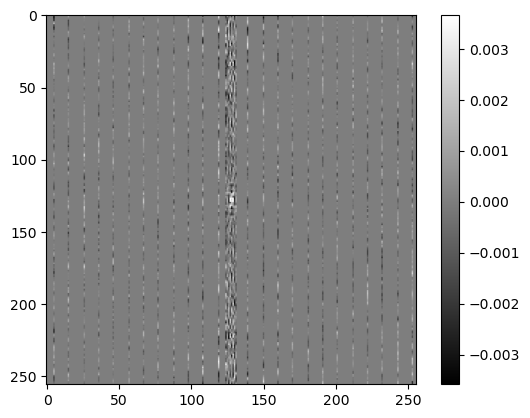

In [52]:
plt.imshow(np.squeeze(R[9]), cmap='gray')
plt.colorbar()

In [50]:
def psnr(gt, pred):
    """ Compute Peak Signal to Noise Ratio metric (PSNR) """
    return peak_signal_noise_ratio(gt, pred, data_range=gt.max())


def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return structural_similarity(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

### pick the worst perturbation across the iterations
P = []
for j, im in enumerate([clean_rec] + pert_recs):
    if j == 0:
        im1 = np.squeeze(norm(orig.copy()))
        im2 = np.squeeze(norm(im.copy()))
        # im1 = (im1-im1.mean()) / im1.std()
        # im1 *= im2.std()
        # im1 += im2.mean()
        #ssim_ = ssim(np.array([im1]),np.array([im2]))
        psnr_c = psnr(np.array([im1]), np.array([im2]))
    if j > 0:
        im1 = np.squeeze(norm(orig.copy()))
        im2 = np.squeeze(norm(im.copy()))
        # im1 = (im1-im1.mean()) / im1.std()
        # im1 *= im2.std()
        # im1 += im2.mean()
        ssim_ = ssim(np.array([im1]), np.array([im2]))
        psnr_ = psnr(np.array([im1]), np.array([im2]))
        P.append(psnr_)
arg = loss.argmin()

/tmp/ipykernel_57559/3931364122.py:8: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(


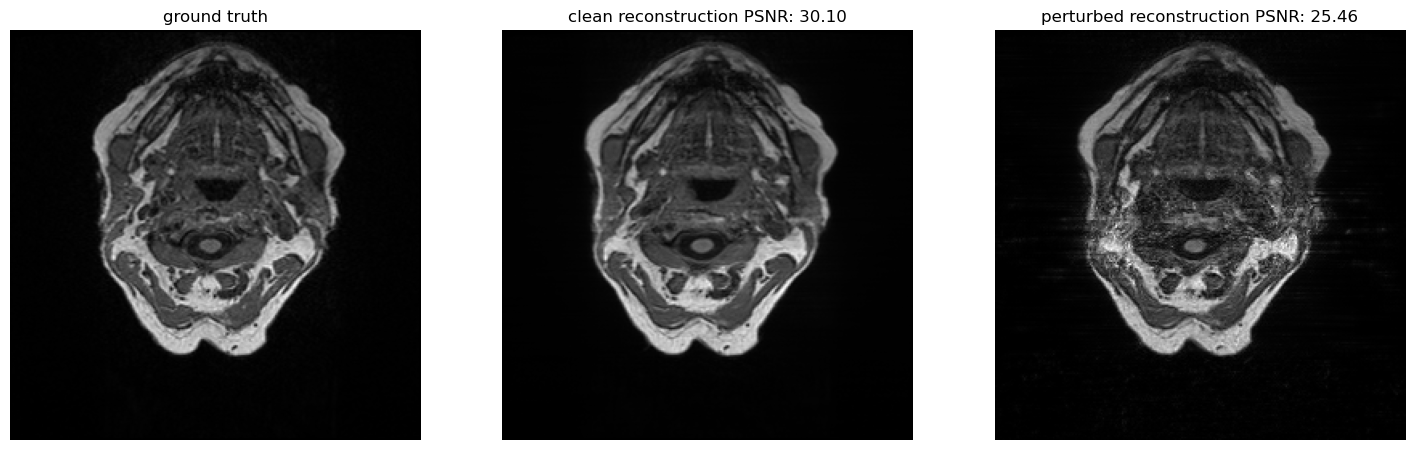

In [51]:
plot_([orig, np.squeeze(clean_rec), np.squeeze(pert_recs[arg])], 
    ['ground truth', 'clean reconstruction', 'perturbed reconstruction'],
    [0, psnr_c, P[arg]])